# Project Data Overview: CRSP Energy Stocks + Commodity Futures

All data needed for the HAR-Lasso Bipartite Network model in one notebook.

**Data sources:**
- **CRSP** (local): S&P 500 Energy stock returns, volume (2000-2020)
- **Yahoo Finance** (downloaded): Commodity futures — WTI Crude, Brent, Natural Gas, Heating Oil

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

DATA_PATH = Path("../US_CRSP_NYSE/Matrix_Format_SubsetUniverse/")
SECTOR_PATH = Path("../US_CRSP_NYSE/Sectors/")

# Install yfinance if needed
try:
    import yfinance as yf
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "yfinance"])
    import yfinance as yf

## 1. Load Data & Extract Energy Stocks

In [2]:
# Load sector mapping
sectors = pd.read_csv(SECTOR_PATH / "Sectors_SP500_YahooNWikipedia.csv")
energy_tickers = sectors.loc[
    sectors['Sector_Wikipedia'] == 'Energy', 'Ticker'
].tolist()
print(f"{len(energy_tickers)} Energy tickers: {energy_tickers}")

25 Energy tickers: ['APA', 'COG', 'COP', 'CVX', 'DVN', 'EOG', 'FTI', 'HAL', 'HES', 'HFC', 'HP', 'KMI', 'MPC', 'MRO', 'NBL', 'NOV', 'OKE', 'OXY', 'PSX', 'PXD', 'SLB', 'VLO', 'WMB', 'XEC', 'XOM']


In [3]:
# Load returns (close-to-close) and transpose to (dates x tickers)
raw_ret = pd.read_csv(DATA_PATH / "pvCLCL_20000103_20201231.csv", index_col=0)
ret = raw_ret.T
ret.index = pd.to_datetime(ret.index.str.replace('X', ''), format='%Y%m%d')
ret.index.name = 'date'

# Filter to energy stocks that exist in the data
energy_avail = [t for t in energy_tickers if t in ret.columns]
missing = [t for t in energy_tickers if t not in ret.columns]
print(f"Available: {len(energy_avail)}, Missing: {missing}")

energy_ret = ret[energy_avail].copy()
print(f"\nEnergy returns shape: {energy_ret.shape}")
print(f"Date range: {energy_ret.index[0].date()} to {energy_ret.index[-1].date()}")
energy_ret.head()

Available: 14, Missing: ['COP', 'CVX', 'FTI', 'HES', 'HFC', 'KMI', 'MPC', 'NBL', 'NOV', 'PSX', 'XEC']

Energy returns shape: (5279, 14)
Date range: 2000-01-03 to 2020-12-31


ticker,APA,COG,DVN,EOG,HAL,HP,MRO,OKE,OXY,PXD,SLB,VLO,WMB,XOM
date,,,,,,,,,,,,,,
2000-01-03,-0.076142,-0.077821,-0.015209,-0.117438,-0.048137,-0.051724,-0.017722,-0.012438,-0.037572,-0.055944,-0.017817,-0.037736,0.014315,-0.029480
2000-01-04,-0.043956,-0.029536,-0.021236,0.000000,0.004894,-0.030303,-0.038660,-0.012594,-0.021021,0.014815,-0.017007,-0.009804,-0.022177,-0.017586
2000-01-05,0.028736,0.017391,0.017751,-0.028226,-0.043831,0.000000,0.026810,0.010204,0.006135,-0.029197,-0.002307,0.036304,0.061856,0.054516
2000-01-06,0.094972,0.021368,0.050388,0.082988,0.040747,0.059375,0.107050,0.000000,0.027439,0.022556,0.068208,0.031847,0.021359,0.049383
2000-01-07,-0.003401,0.041841,0.005535,-0.015326,0.061990,0.023599,0.028302,0.037879,0.029674,0.029412,0.018398,-0.012346,0.026616,-0.000735


In [4]:
# Load open-to-close returns (needed for OFI proxy later)
raw_opcl = pd.read_csv(DATA_PATH / "OPCL_20000103_20201231.csv", index_col=0)
opcl = raw_opcl.T
opcl.index = pd.to_datetime(opcl.index.str.replace('X', ''), format='%Y%m%d')
energy_opcl = opcl[energy_avail].copy()

# Load volume
raw_vol = pd.read_csv(DATA_PATH / "volume_20000103_20201231.csv", index_col=0)
vol = raw_vol.T
vol.index = pd.to_datetime(vol.index.str.replace('X', ''), format='%Y%m%d')
energy_vol = vol[energy_avail].copy()

print(f"OPCL shape: {energy_opcl.shape}, Volume shape: {energy_vol.shape}")

OPCL shape: (5279, 14), Volume shape: (5279, 14)


## 2. Missing Data & Coverage

Missing data % per Energy stock:
ticker
APA    0.0
COG    0.0
DVN    0.0
EOG    0.0
HAL    0.0
HP     0.0
MRO    0.0
OKE    0.0
OXY    0.0
PXD    0.0
SLB    0.0
VLO    0.0
WMB    0.0
XOM    0.0


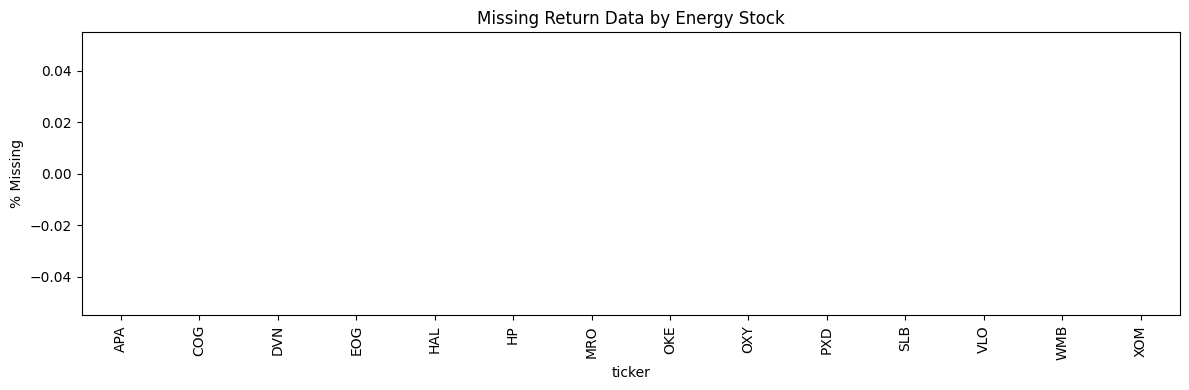

In [5]:
# Missing data per stock
missing_pct = energy_ret.isna().mean().sort_values(ascending=False) * 100
print("Missing data % per Energy stock:")
print(missing_pct.to_string())

fig, ax = plt.subplots(figsize=(12, 4))
missing_pct.plot.bar(ax=ax, color='salmon')
ax.set_ylabel('% Missing')
ax.set_title('Missing Return Data by Energy Stock')
plt.tight_layout()
plt.show()

In [6]:
# First valid date per stock (some IPO'd later)
first_valid = energy_ret.apply(lambda s: s.first_valid_index())
print("\nFirst valid date per stock:")
print(first_valid.sort_values().to_string())


First valid date per stock:
ticker
APA   2000-01-03
COG   2000-01-03
DVN   2000-01-03
EOG   2000-01-03
HAL   2000-01-03
HP    2000-01-03
MRO   2000-01-03
OKE   2000-01-03
OXY   2000-01-03
PXD   2000-01-03
SLB   2000-01-03
VLO   2000-01-03
WMB   2000-01-03
XOM   2000-01-03


## 3. Geopolitical Events Timeline

Major oil/energy geopolitical events in the 2000-2020 window.

In [7]:
EVENTS = {
    '2001-09-11': '9/11 Attacks',
    '2003-03-20': 'Iraq War Begins',
    '2005-08-29': 'Hurricane Katrina',
    '2008-07-03': 'Oil Hits $147 Peak',
    '2008-09-15': 'Lehman Brothers Collapse',
    '2011-02-15': 'Libyan Civil War / Arab Spring',
    '2014-11-27': 'OPEC Refuses to Cut (Oil Crash)',
    '2016-01-20': 'Oil Hits $26 Bottom',
    '2018-05-08': 'US Exits Iran Nuclear Deal',
    '2018-11-05': 'Iran Oil Sanctions Reimposed',
    '2019-01-28': 'US Sanctions on Venezuela (PDVSA)',
    '2019-09-14': 'Saudi Aramco Drone Attack',
    '2020-01-03': 'Soleimani Assassination',
    '2020-03-09': 'Saudi-Russia Oil Price War',
    '2020-04-20': 'WTI Goes Negative',
}

events_df = pd.DataFrame([
    {'date': pd.Timestamp(d), 'event': e} for d, e in EVENTS.items()
])
events_df

,date,event
0,2001-09-11,9/11 Attacks
1,2003-03-20,Iraq War Begins
2,2005-08-29,Hurricane Katrina
3,2008-07-03,Oil Hits $147 Peak
4,2008-09-15,Lehman Brothers Collapse
5,2011-02-15,Libyan Civil War / Arab Spring
6,2014-11-27,OPEC Refuses to Cut (Oil Crash)
7,2016-01-20,Oil Hits $26 Bottom
8,2018-05-08,US Exits Iran Nuclear Deal
9,2018-11-05,Iran Oil Sanctions Reimposed


## 4. Energy Sector Cumulative Returns with Event Markers

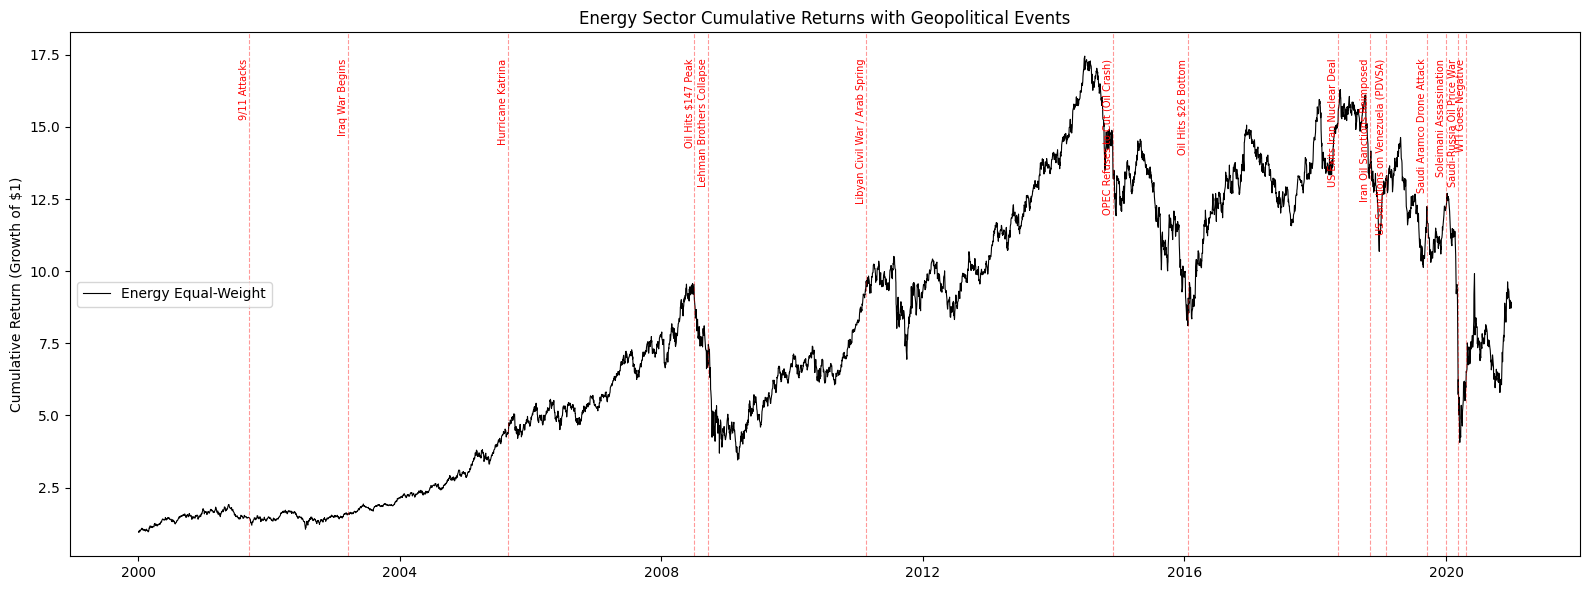

In [8]:
# Equal-weighted energy portfolio
energy_eq = energy_ret.mean(axis=1).dropna()
energy_cum = (1 + energy_eq).cumprod()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(energy_cum, color='black', linewidth=0.8, label='Energy Equal-Weight')

# Mark events
for _, row in events_df.iterrows():
    if row['date'] >= energy_cum.index[0]:
        ax.axvline(row['date'], color='red', alpha=0.4, linestyle='--', linewidth=0.8)
        ypos = ax.get_ylim()[1] * 0.95
        ax.text(row['date'], ypos, row['event'], rotation=90,
                fontsize=7, va='top', ha='right', color='red')

ax.set_title('Energy Sector Cumulative Returns with Geopolitical Events')
ax.set_ylabel('Cumulative Return (Growth of $1)')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Rolling Volatility Around Events

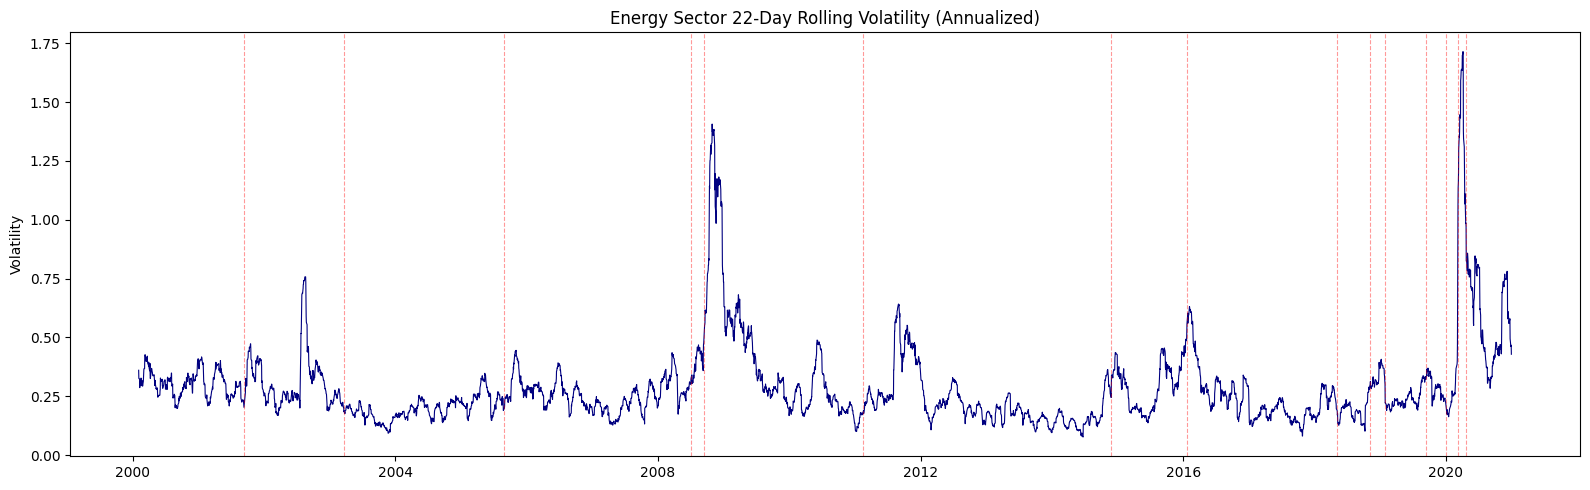

In [9]:
# 22-day rolling vol (annualized)
rolling_vol = energy_eq.rolling(22).std() * np.sqrt(252)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(rolling_vol, color='navy', linewidth=0.8)
for _, row in events_df.iterrows():
    if row['date'] >= rolling_vol.dropna().index[0]:
        ax.axvline(row['date'], color='red', alpha=0.4, linestyle='--', linewidth=0.8)

ax.set_title('Energy Sector 22-Day Rolling Volatility (Annualized)')
ax.set_ylabel('Volatility')
plt.tight_layout()
plt.show()

## 6. Cross-Sectional Correlation Structure

How correlated are energy stocks with each other? This matters for the bipartite graph — if all energy stocks move together, the network edges will look similar.

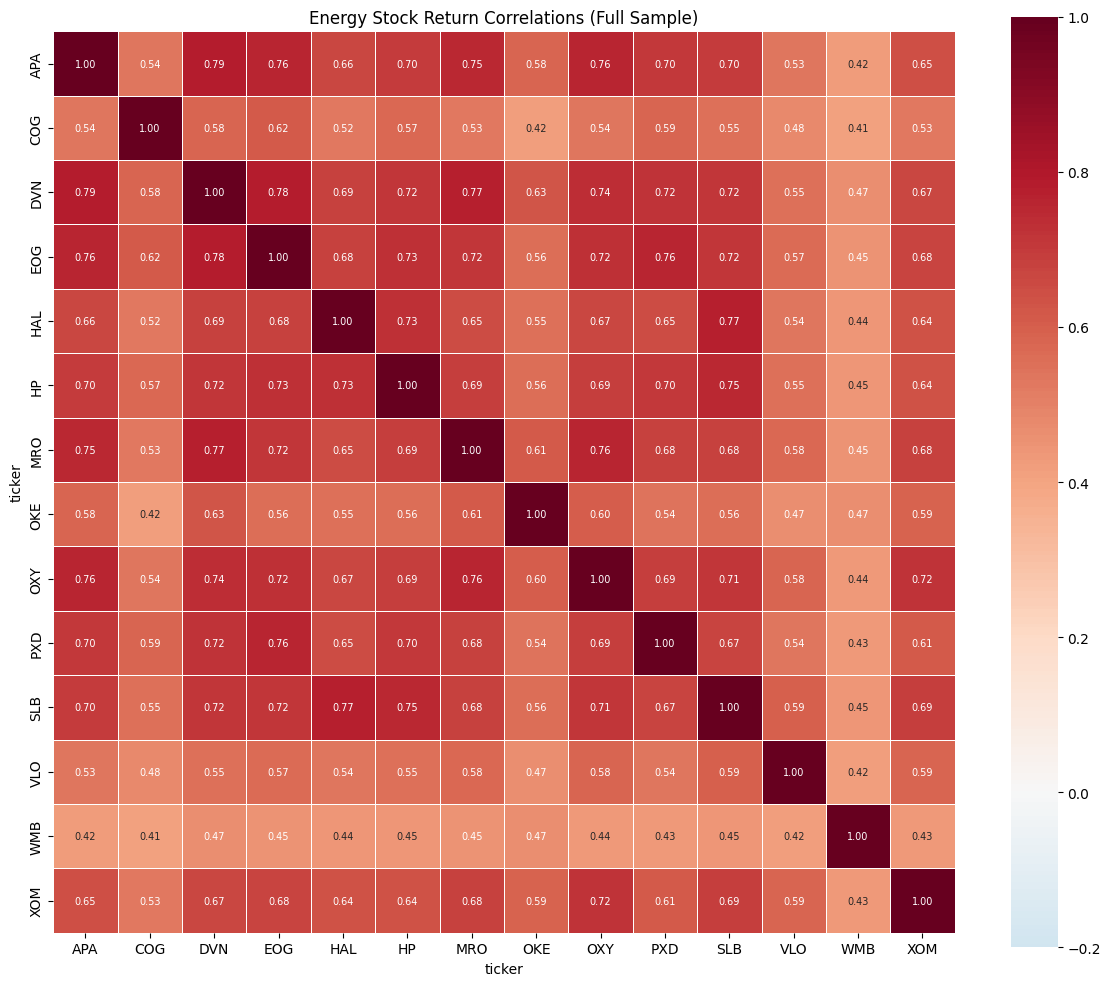

In [10]:
# Full-sample correlation
corr = energy_ret.corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, cmap='RdBu_r', center=0, vmin=-0.2, vmax=1,
            square=True, linewidths=0.5, annot=True, fmt='.2f', ax=ax,
            annot_kws={'size': 7})
ax.set_title('Energy Stock Return Correlations (Full Sample)')
plt.tight_layout()
plt.show()

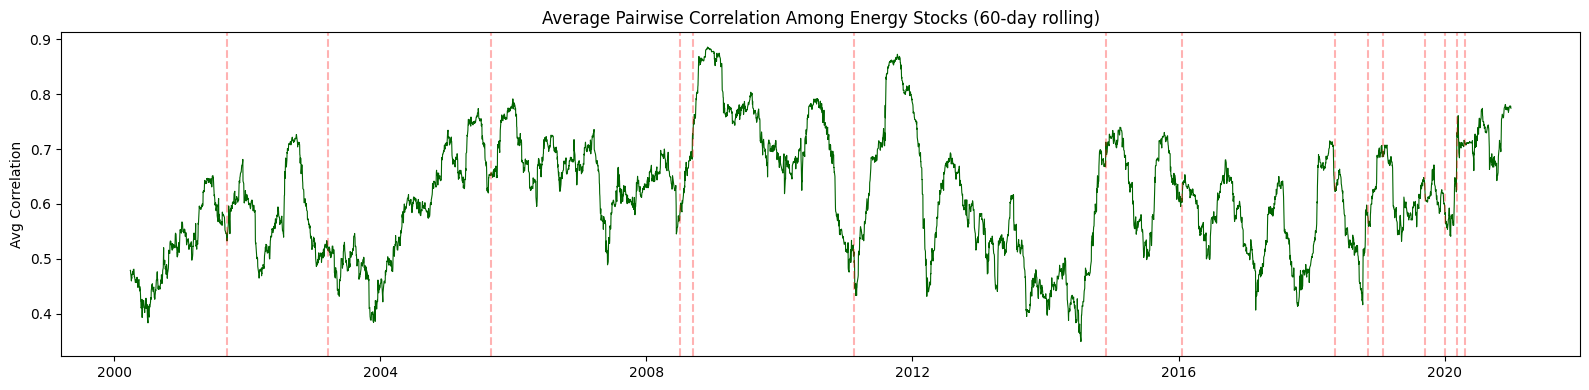

In [11]:
# Rolling average pairwise correlation (captures regime changes)
window = 60
rolling_corr_avg = energy_ret.rolling(window).corr().groupby(level=0).mean().mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(rolling_corr_avg, color='darkgreen', linewidth=0.8)
for _, row in events_df.iterrows():
    if row['date'] >= rolling_corr_avg.dropna().index[0]:
        ax.axvline(row['date'], color='red', alpha=0.3, linestyle='--')

ax.set_title(f'Average Pairwise Correlation Among Energy Stocks ({window}-day rolling)')
ax.set_ylabel('Avg Correlation')
plt.tight_layout()
plt.show()

## 7. Event Windows: Return Distribution Shifts

Compare return distributions pre/post event to see how shocks alter the cross-section.

In [12]:
def event_window_stats(returns, event_date, event_name, pre_days=60, post_days=60):
    """Compare energy stock behavior before and after a geopolitical event."""
    event_dt = pd.Timestamp(event_date)
    pre = returns.loc[:event_dt].iloc[-pre_days:]
    post = returns.loc[event_dt:].iloc[:post_days]

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(f'{event_name} ({event_date})', fontsize=13, fontweight='bold')

    # Cumulative returns around event
    window = pd.concat([pre, post])
    cum = (1 + window).cumprod()
    cum.plot(ax=axes[0], legend=False, alpha=0.6, linewidth=0.8)
    axes[0].axvline(event_dt, color='red', linestyle='--', linewidth=1.5)
    axes[0].set_title('Cumulative Returns (Individual Stocks)')

    # Volatility comparison
    vol_pre = pre.std() * np.sqrt(252)
    vol_post = post.std() * np.sqrt(252)
    vol_comp = pd.DataFrame({'Pre': vol_pre, 'Post': vol_post})
    vol_comp.plot.bar(ax=axes[1], color=['steelblue', 'coral'])
    axes[1].set_title('Annualized Vol: Pre vs Post')
    axes[1].tick_params(axis='x', rotation=45)

    # Correlation comparison
    corr_pre = pre.corr().values
    corr_post = post.corr().values
    mask = np.triu(np.ones_like(corr_pre, dtype=bool), k=1)
    axes[2].hist(corr_pre[mask], bins=20, alpha=0.6, color='steelblue', label=f'Pre (mean={corr_pre[mask].mean():.2f})')
    axes[2].hist(corr_post[mask], bins=20, alpha=0.6, color='coral', label=f'Post (mean={corr_post[mask].mean():.2f})')
    axes[2].legend(fontsize=8)
    axes[2].set_title('Pairwise Correlation Distribution')

    plt.tight_layout()
    plt.show()

    # Summary stats
    print(f"  Mean daily return — Pre: {pre.mean().mean():.5f}, Post: {post.mean().mean():.5f}")
    print(f"  Mean annualized vol — Pre: {vol_pre.mean():.4f}, Post: {vol_post.mean():.4f}")
    print(f"  Mean pairwise corr — Pre: {corr_pre[mask].mean():.4f}, Post: {corr_post[mask].mean():.4f}")
    print()

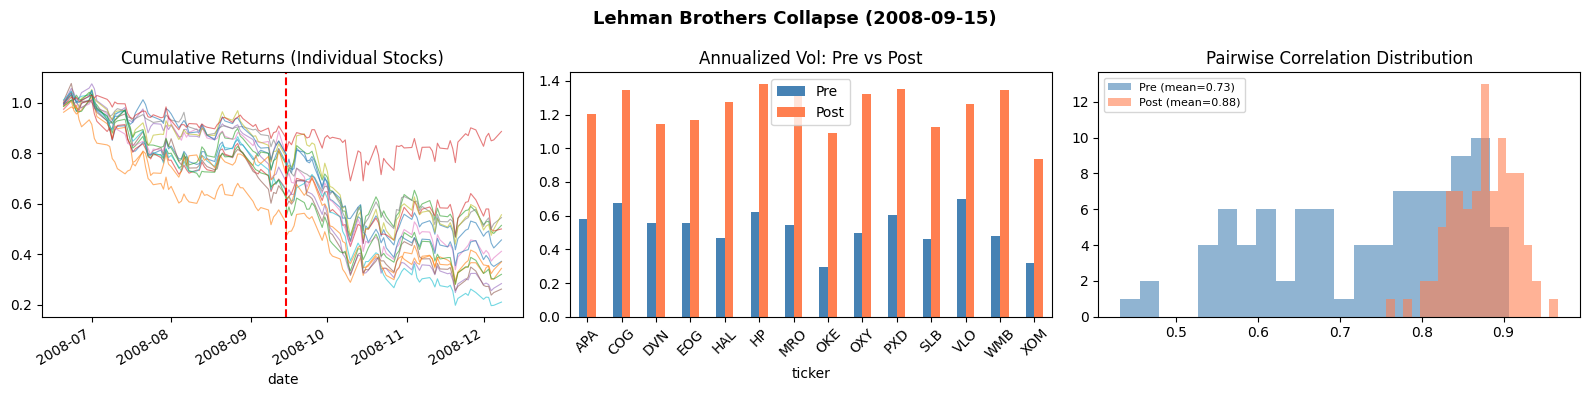

  Mean daily return — Pre: -0.00515, Post: -0.00633
  Mean annualized vol — Pre: 0.5255, Post: 1.2340
  Mean pairwise corr — Pre: 0.7310, Post: 0.8755



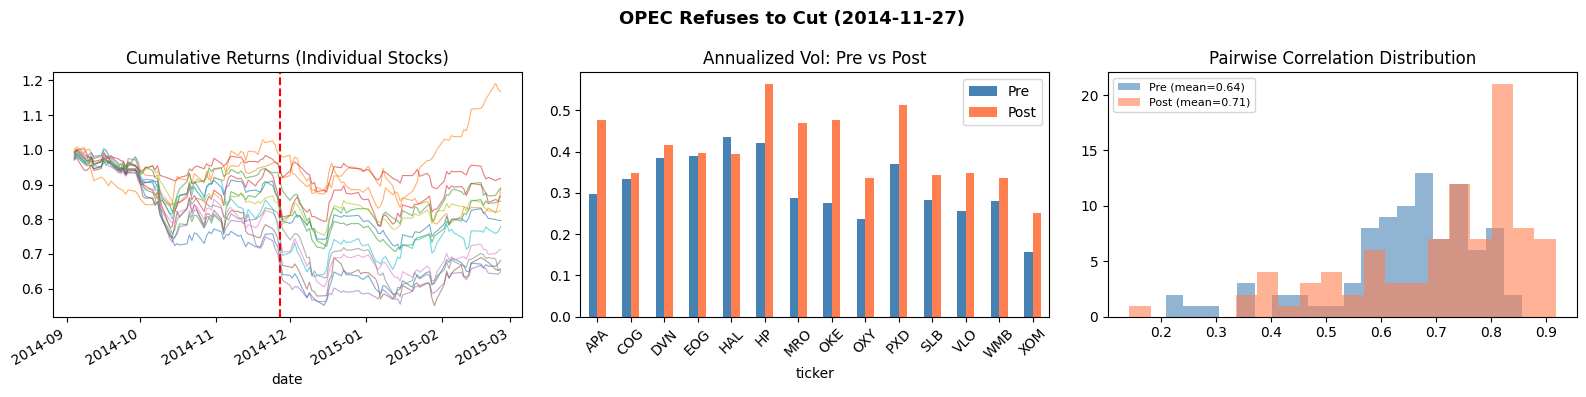

  Mean daily return — Pre: -0.00265, Post: -0.00053
  Mean annualized vol — Pre: 0.3147, Post: 0.4053
  Mean pairwise corr — Pre: 0.6426, Post: 0.7079



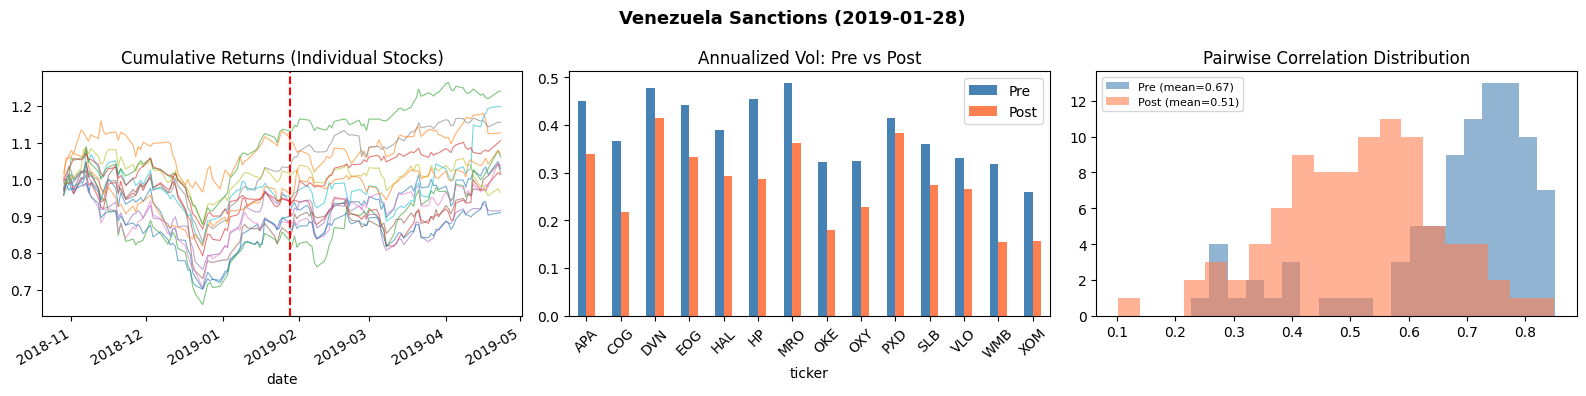

  Mean daily return — Pre: -0.00053, Post: 0.00190
  Mean annualized vol — Pre: 0.3854, Post: 0.2775
  Mean pairwise corr — Pre: 0.6711, Post: 0.5132



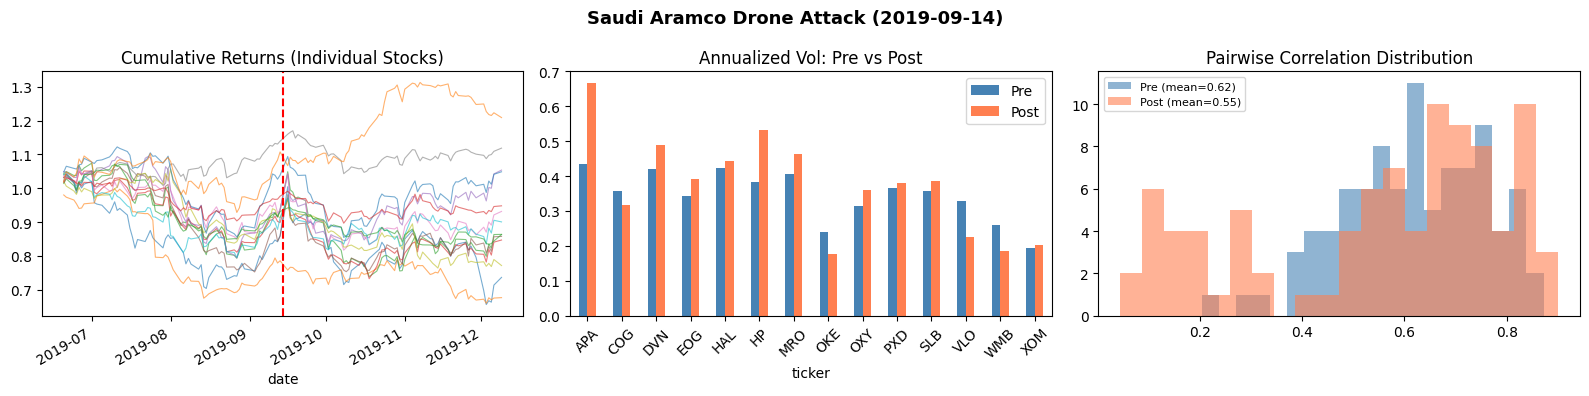

  Mean daily return — Pre: -0.00078, Post: -0.00034
  Mean annualized vol — Pre: 0.3450, Post: 0.3728
  Mean pairwise corr — Pre: 0.6150, Post: 0.5545



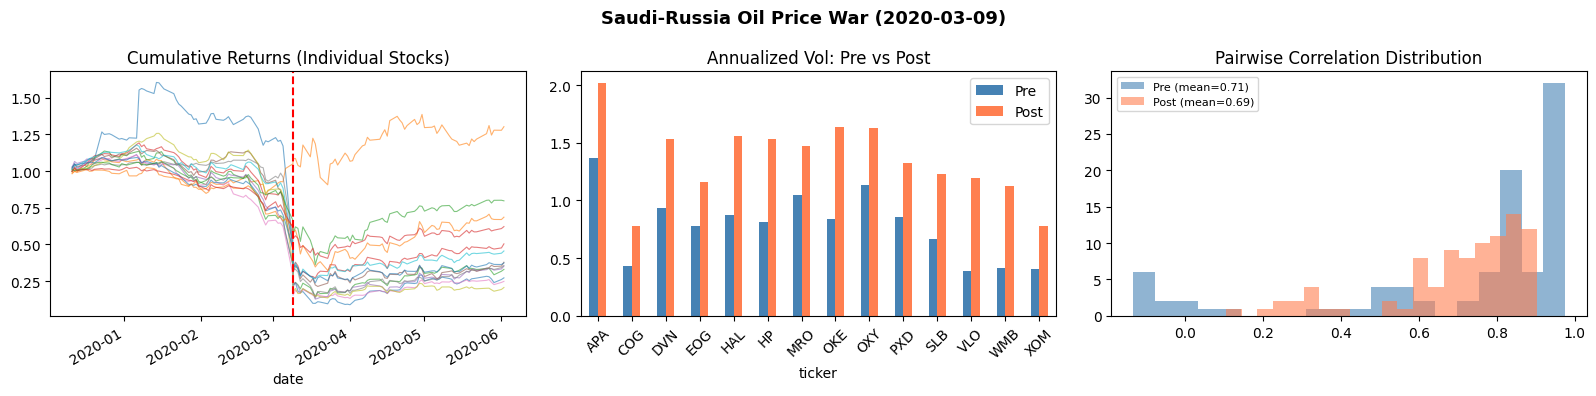

  Mean daily return — Pre: -0.01002, Post: 0.00216
  Mean annualized vol — Pre: 0.7812, Post: 1.3551
  Mean pairwise corr — Pre: 0.7079, Post: 0.6935



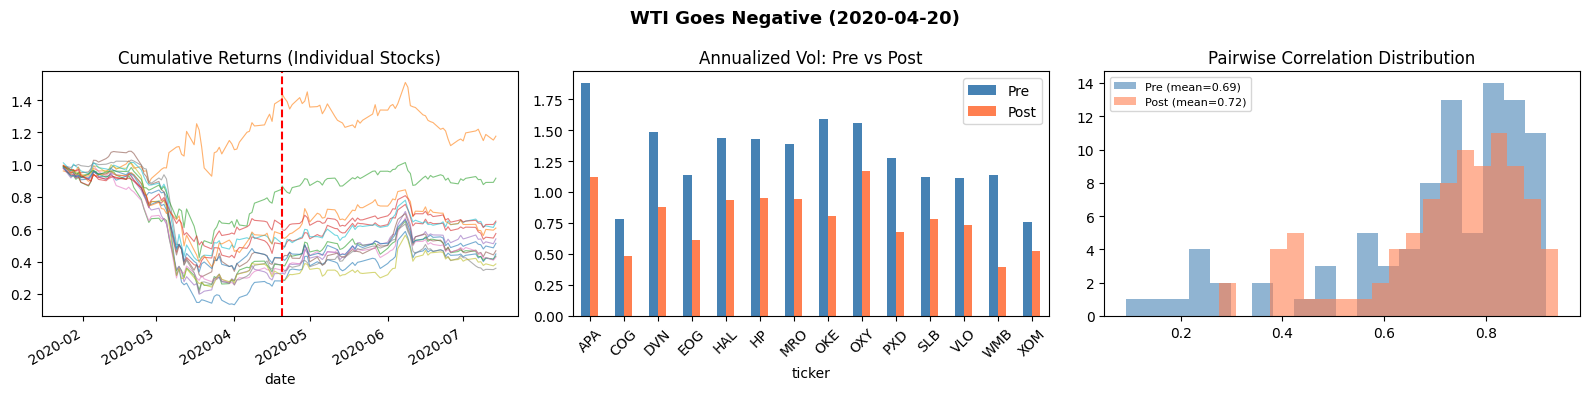

  Mean daily return — Pre: -0.00855, Post: 0.00382
  Mean annualized vol — Pre: 1.2921, Post: 0.7859
  Mean pairwise corr — Pre: 0.6926, Post: 0.7188



In [13]:
# Analyze key events
key_events = [
    ('2008-09-15', 'Lehman Brothers Collapse'),
    ('2014-11-27', 'OPEC Refuses to Cut'),
    ('2019-01-28', 'Venezuela Sanctions'),
    ('2019-09-14', 'Saudi Aramco Drone Attack'),
    ('2020-03-09', 'Saudi-Russia Oil Price War'),
    ('2020-04-20', 'WTI Goes Negative'),
]

for date, name in key_events:
    event_window_stats(energy_ret, date, name)

## 8. HAR Feature Preview

Simulate what the HAR features look like for the energy sector itself (before we add commodities).  
This shows the multi-scale decomposition: daily vs weekly vs monthly signals.

In [14]:
# Use equal-weighted energy portfolio as a proxy
r = energy_eq.dropna().copy()

har_df = pd.DataFrame(index=r.index)
har_df['r_daily'] = r.shift(1)               # r^(d)_{t-1}
har_df['r_weekly'] = r.rolling(5).mean().shift(1)   # r^(w)_{t-1}
har_df['r_monthly'] = r.rolling(22).mean().shift(1)  # r^(m)_{t-1}
har_df = har_df.dropna()

print(f"HAR features shape: {har_df.shape}")
har_df.describe()

HAR features shape: (5257, 3)


,r_daily,r_weekly,r_monthly
count,5257.000000,5257.000000,5257.000000
mean,0.000636,0.000635,0.000640
std,0.021199,0.009165,0.004342
min,-0.302757,-0.101061,-0.041236
25%,-0.009383,-0.003951,-0.001437
50%,0.000525,0.001019,0.000931
75%,0.011390,0.005618,0.003084
max,0.213124,0.058238,0.021448


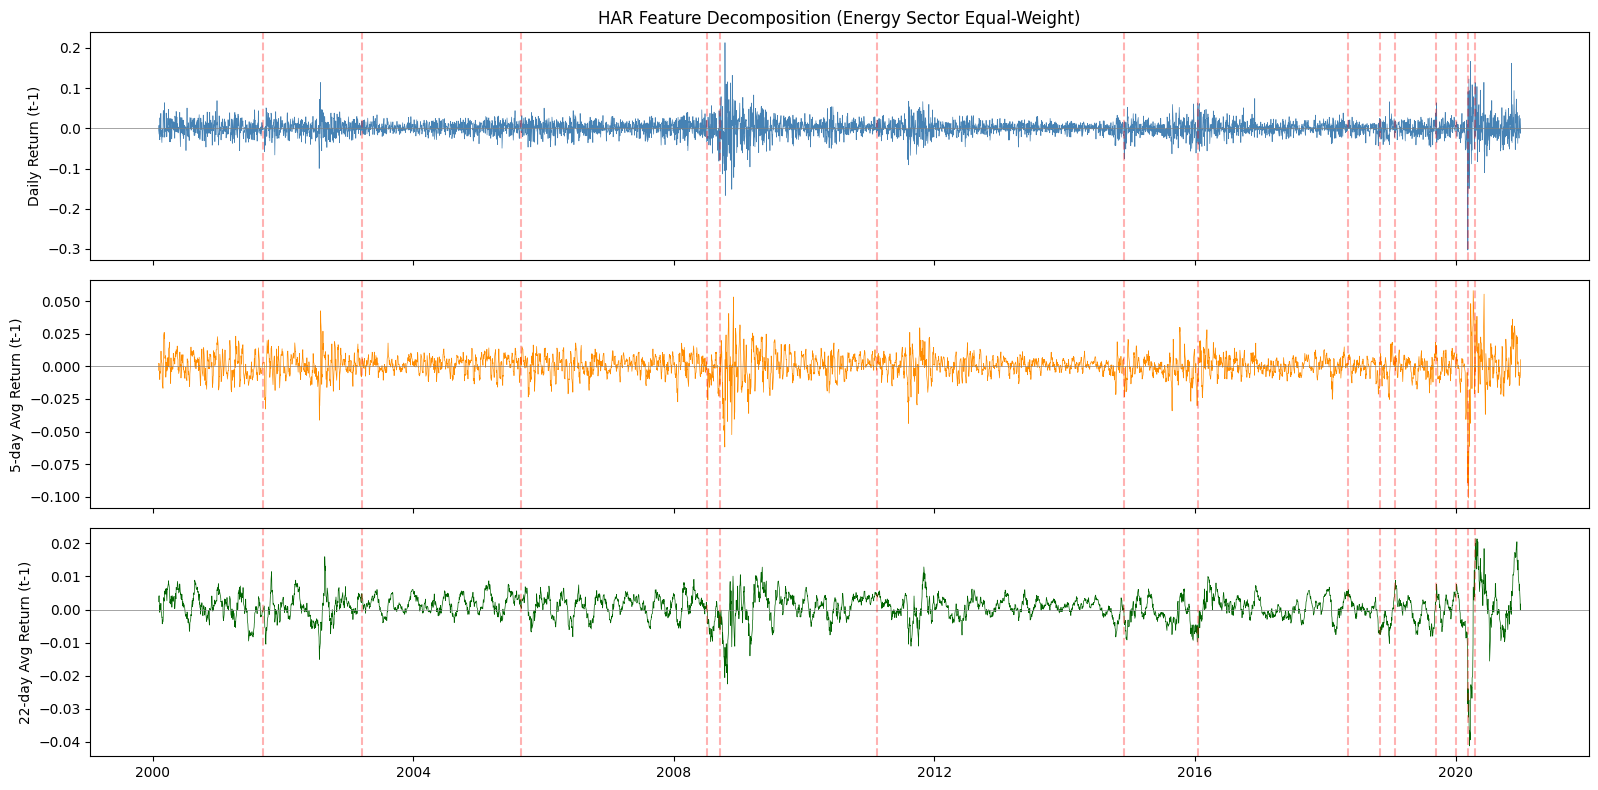

In [15]:
# Visualize HAR features over time
fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)

for ax, col, color, label in zip(axes,
    ['r_daily', 'r_weekly', 'r_monthly'],
    ['steelblue', 'darkorange', 'darkgreen'],
    ['Daily Return (t-1)', '5-day Avg Return (t-1)', '22-day Avg Return (t-1)']):

    ax.plot(har_df[col], color=color, linewidth=0.5)
    ax.set_ylabel(label)
    ax.axhline(0, color='gray', linewidth=0.5)
    for _, row in events_df.iterrows():
        if row['date'] >= har_df.index[0]:
            ax.axvline(row['date'], color='red', alpha=0.3, linestyle='--')

axes[0].set_title('HAR Feature Decomposition (Energy Sector Equal-Weight)')
plt.tight_layout()
plt.show()

In [16]:
# Correlation between HAR horizons
print("HAR feature correlations:")
print(har_df.corr().to_string())

HAR feature correlations:
            r_daily  r_weekly  r_monthly
r_daily    1.000000  0.434440   0.209764
r_weekly   0.434440  1.000000   0.472874
r_monthly  0.209764  0.472874   1.000000


## 9. Individual Stock Heterogeneity

Not all energy stocks are the same. Majors (XOM, CVX) vs E&P (PXD, EOG) vs Services (SLB, HAL) likely respond differently to commodity shocks. This is what the Lasso should capture.

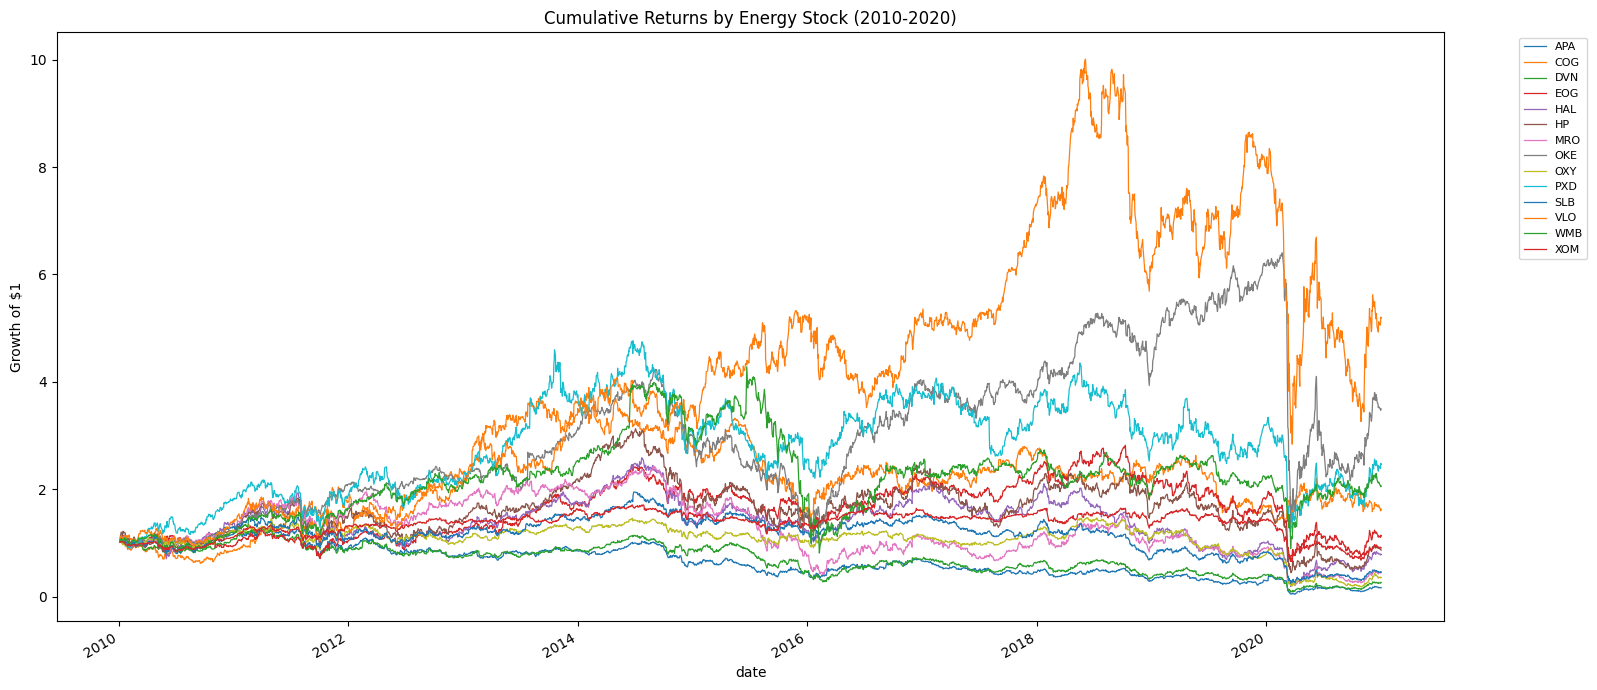

In [17]:
# Cumulative returns by stock
fig, ax = plt.subplots(figsize=(16, 7))
(1 + energy_ret.loc['2010':]).cumprod().plot(ax=ax, linewidth=0.9)
ax.set_title('Cumulative Returns by Energy Stock (2010-2020)')
ax.set_ylabel('Growth of $1')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

        Ann. Return  Ann. Vol    Sharpe
ticker                                 
VLO        0.228117  0.396564  0.575235
OKE        0.197179  0.401536  0.491061
PXD        0.171888  0.419553  0.409694
WMB        0.153614  0.417391  0.368033
COG        0.117762  0.385370  0.305582
EOG        0.085108  0.381654  0.222999
HP         0.092429  0.456381  0.202527
HAL        0.074132  0.432323  0.171473
MRO        0.043316  0.474350  0.091317
XOM        0.019726  0.238114  0.082842
OXY       -0.003730  0.413285 -0.009025
SLB       -0.006673  0.353956 -0.018853
DVN       -0.015566  0.456666 -0.034085
APA       -0.026668  0.505465 -0.052759


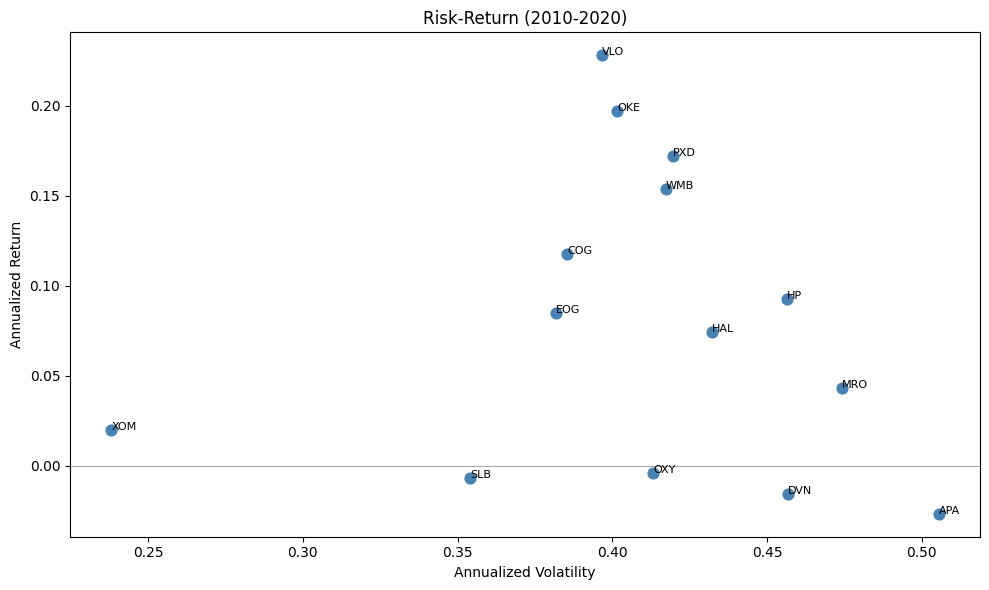

In [18]:
# Annualized return & vol summary (2010-2020)
period = energy_ret.loc['2010':]
ann_ret = period.mean() * 252
ann_vol = period.std() * np.sqrt(252)

summary = pd.DataFrame({'Ann. Return': ann_ret, 'Ann. Vol': ann_vol})
summary['Sharpe'] = summary['Ann. Return'] / summary['Ann. Vol']
summary = summary.sort_values('Sharpe', ascending=False)

print(summary.to_string())

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(summary['Ann. Vol'], summary['Ann. Return'], s=60, color='steelblue')
for ticker in summary.index:
    ax.annotate(ticker, (summary.loc[ticker, 'Ann. Vol'], summary.loc[ticker, 'Ann. Return']),
                fontsize=8, ha='left')
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Return')
ax.set_title('Risk-Return (2010-2020)')
ax.axhline(0, color='gray', linewidth=0.5)
plt.tight_layout()
plt.show()

## 10. Daily OFI Proxy Preview

We can approximate OFI from close-to-close vs open-to-close returns.  
The difference `pvCLCL - OPCL` captures the overnight return component.

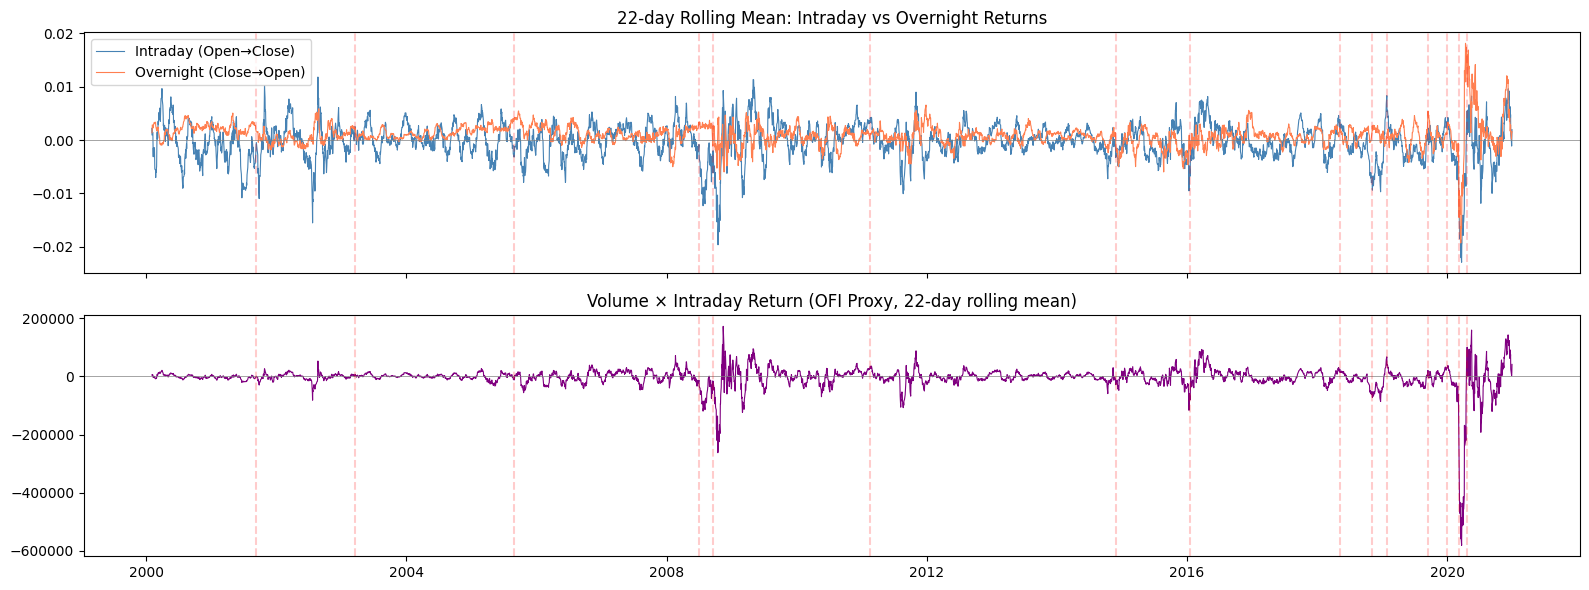

In [19]:
# Overnight vs intraday return decomposition
intraday = energy_opcl.mean(axis=1).dropna()  # open-to-close
total = energy_eq.dropna()  # close-to-close
overnight = total - intraday  # close-to-open

fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
axes[0].plot(intraday.rolling(22).mean(), color='steelblue', linewidth=0.8, label='Intraday (Open→Close)')
axes[0].plot(overnight.rolling(22).mean(), color='coral', linewidth=0.8, label='Overnight (Close→Open)')
axes[0].legend()
axes[0].set_title('22-day Rolling Mean: Intraday vs Overnight Returns')
axes[0].axhline(0, color='gray', linewidth=0.5)

# Volume-weighted direction (rough OFI proxy using available data)
mean_vol = energy_vol.mean(axis=1).dropna()
ofi_proxy = mean_vol * intraday
axes[1].plot(ofi_proxy.rolling(22).mean(), color='purple', linewidth=0.8)
axes[1].set_title('Volume × Intraday Return (OFI Proxy, 22-day rolling mean)')
axes[1].axhline(0, color='gray', linewidth=0.5)

for ax in axes:
    for _, row in events_df.iterrows():
        if row['date'] >= intraday.index[0]:
            ax.axvline(row['date'], color='red', alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

---

# PART B: Commodity Futures Data

The other side of the bipartite graph. These are the **predictors** in the Lasso model.

## 11. Download Commodity Futures from Yahoo Finance

In [20]:
# Upgrade yfinance first (old versions can't fetch futures)
import subprocess
subprocess.check_call(["pip", "install", "--upgrade", "yfinance", "-q"])
import importlib
import yfinance as yf
importlib.reload(yf)
print(f"yfinance version: {yf.__version__}")

COMMODITY_TICKERS = {
    'CL=F': 'WTI Crude',
    'BZ=F': 'Brent Crude',
    'NG=F': 'Natural Gas',
    'HO=F': 'Heating Oil',
}

# Download futures individually
comm_prices = {}
for ticker, name in COMMODITY_TICKERS.items():
    try:
        df = yf.download(ticker, start='2000-01-01', end='2020-12-31', auto_adjust=True, progress=False)
        if len(df) > 0:
            # yfinance >= 1.0 may return MultiIndex columns like ('Close', 'CL=F')
            if isinstance(df.columns, pd.MultiIndex):
                close = df['Close'].iloc[:, 0]
            else:
                close = df['Close']
            comm_prices[name] = close
            print(f"  {name} ({ticker}): {len(close)} rows")
    except Exception as e:
        print(f"  {name} ({ticker}): FAILED - {e}")

comm_close = pd.DataFrame(comm_prices)
comm_close.index = pd.to_datetime(comm_close.index)
if comm_close.index.tz is not None:
    comm_close.index = comm_close.index.tz_localize(None)
comm_close.index.name = 'date'

print(f"\nCommodity prices shape: {comm_close.shape}")
print(f"Date range: {comm_close.index[0].date()} to {comm_close.index[-1].date()}")
print(f"\nFirst valid date per commodity:")
print(comm_close.apply(lambda s: s.first_valid_index()))
comm_close.tail()


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: pip install --upgrade pip


yfinance version: 1.1.0
  WTI Crude (CL=F): 5109 rows
  Brent Crude (BZ=F): 3326 rows
  Natural Gas (NG=F): 5105 rows
  Heating Oil (HO=F): 5102 rows

Commodity prices shape: (5111, 4)
Date range: 2000-08-23 to 2020-12-30

First valid date per commodity:
WTI Crude     2000-08-23
Brent Crude   2007-07-30
Natural Gas   2000-08-30
Heating Oil   2000-09-01
dtype: datetime64[ns]


,WTI Crude,Brent Crude,Natural Gas,Heating Oil
date,,,,
2020-12-23,48.119999,51.200001,2.608,1.4975
2020-12-24,48.230000,51.290001,2.518,1.4900
2020-12-28,47.619999,50.860001,2.305,1.4790
2020-12-29,48.000000,51.090000,2.467,1.4868
2020-12-30,48.400002,51.340000,2.422,1.4898


## 12. Commodity Price History with Geopolitical Events

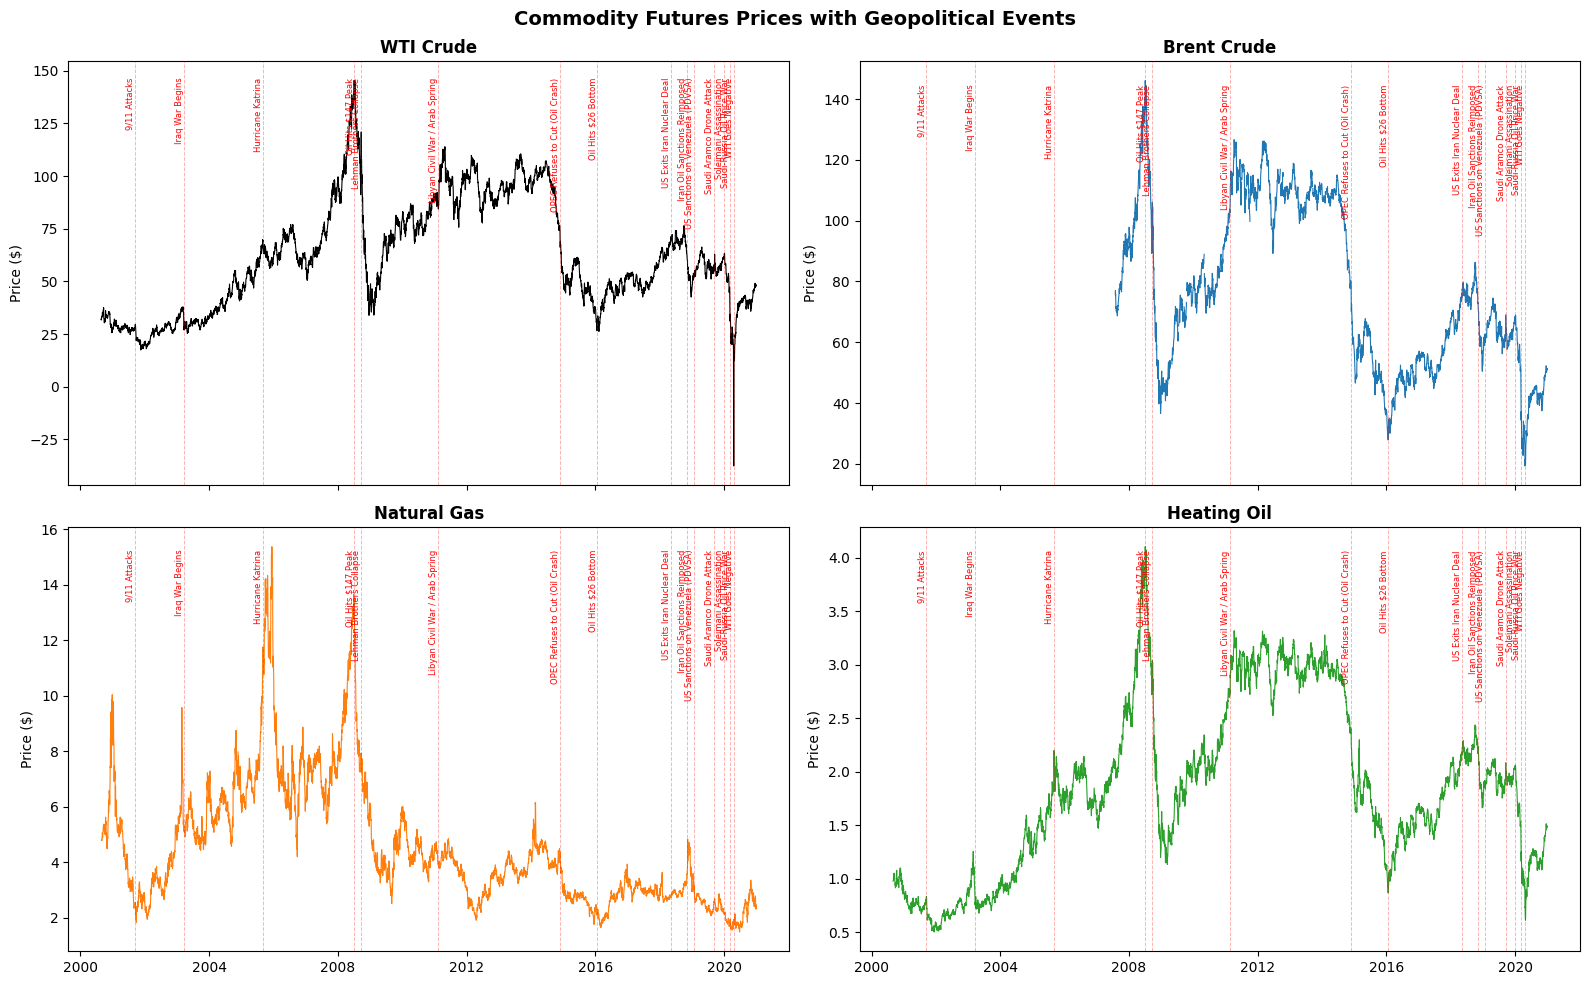

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
colors = ['black', 'tab:blue', 'tab:orange', 'tab:green']

for ax, (col, color) in zip(axes.flat, zip(comm_close.columns, colors)):
    ax.plot(comm_close[col], color=color, linewidth=0.8)
    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_ylabel('Price ($)')
    for _, row in events_df.iterrows():
        if row['date'] >= comm_close.index[0]:
            ax.axvline(row['date'], color='red', alpha=0.3, linestyle='--', linewidth=0.7)
            ax.text(row['date'], ax.get_ylim()[1] * 0.95, row['event'],
                    rotation=90, fontsize=6, va='top', ha='right', color='red')

plt.suptitle('Commodity Futures Prices with Geopolitical Events', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 13. Commodity Returns & HAR Features (Model Inputs)

These are the actual X variables that go into the Lasso regression.

In [22]:
# Compute commodity daily returns
comm_ret = comm_close.pct_change(fill_method=None).dropna()

# WTI went negative in April 2020 — pct_change produces extreme artifacts
# Clip extreme returns (>100% daily move is not meaningful for the model)
extreme_mask = comm_ret.abs() > 1.0
if extreme_mask.any().any():
    print("Extreme return outliers detected (|r| > 100%):")
    for col in comm_ret.columns:
        extremes = comm_ret.loc[extreme_mask[col], col]
        if len(extremes) > 0:
            print(f"  {col}: {len(extremes)} days — {extremes.index.date.tolist()}")
    comm_ret = comm_ret.clip(-1.0, 1.0)
    print("  → Clipped to [-100%, +100%]\n")

print(f"Commodity returns shape: {comm_ret.shape}")
print(f"\nSummary stats:")
print(comm_ret.describe().to_string())

Extreme return outliers detected (|r| > 100%):
  WTI Crude: 2 days — [datetime.date(2020, 4, 20), datetime.date(2020, 4, 21)]
  → Clipped to [-100%, +100%]

Commodity returns shape: (3285, 4)

Summary stats:
         WTI Crude  Brent Crude  Natural Gas  Heating Oil
count  3285.000000  3285.000000  3285.000000  3285.000000
mean     -0.000247     0.000108     0.000011     0.000092
std       0.037590     0.024130     0.031687     0.021485
min      -1.000000    -0.244036    -0.165185    -0.181235
25%      -0.012069    -0.010051    -0.018483    -0.010415
50%       0.000401     0.000346    -0.000642     0.000505
75%       0.012242     0.010643     0.016264     0.010654
max       0.376623     0.210186     0.306971     0.115677


In [23]:
# Build HAR features for each commodity: X_c = [r_daily, r_weekly, r_monthly]
har_features = {}
for commodity in comm_ret.columns:
    r_c = comm_ret[commodity].dropna()
    har_c = pd.DataFrame(index=r_c.index)
    har_c[f'{commodity}_daily']   = r_c.shift(1)
    har_c[f'{commodity}_weekly']  = r_c.rolling(5).mean().shift(1)
    har_c[f'{commodity}_monthly'] = r_c.rolling(22).mean().shift(1)
    har_features[commodity] = har_c

# Combine all into one feature matrix
X_har = pd.concat(har_features.values(), axis=1).dropna()
print(f"Combined HAR feature matrix: {X_har.shape}")
print(f"Columns (these are the Lasso predictors):")
for i, col in enumerate(X_har.columns, 1):
    print(f"  {i}. {col}")
print(f"\nDate range: {X_har.index[0].date()} to {X_har.index[-1].date()}")
X_har.head()

Combined HAR feature matrix: (3263, 12)
Columns (these are the Lasso predictors):
  1. WTI Crude_daily
  2. WTI Crude_weekly
  3. WTI Crude_monthly
  4. Brent Crude_daily
  5. Brent Crude_weekly
  6. Brent Crude_monthly
  7. Natural Gas_daily
  8. Natural Gas_weekly
  9. Natural Gas_monthly
  10. Heating Oil_daily
  11. Heating Oil_weekly
  12. Heating Oil_monthly

Date range: 2007-08-30 to 2020-12-30


,WTI Crude_daily,WTI Crude_weekly,WTI Crude_monthly,Brent Crude_daily,Brent Crude_weekly,Brent Crude_monthly,Natural Gas_daily,Natural Gas_weekly,Natural Gas_monthly,Heating Oil_daily,Heating Oil_weekly,Heating Oil_monthly
date,,,,,,,,,,,,
2007-08-30,0.024815,0.012027,-0.001855,0.022395,0.009839,-0.002082,-0.029144,-0.005033,-0.007301,0.022842,0.009482,-0.000369
2007-08-31,-0.002041,0.009972,-0.002764,-0.003189,0.005824,-0.003013,0.037753,0.000940,-0.003431,-0.006611,0.006856,-0.001437
2007-09-04,0.009269,0.008218,-0.001367,0.010987,0.005846,-0.001511,-0.029636,-0.001465,-0.005960,0.006803,0.004525,-0.000466
2007-09-05,0.014046,0.008551,-0.000924,0.016921,0.008296,-0.000989,0.029444,0.009602,-0.002862,0.018265,0.006926,0.000250
2007-09-06,0.008657,0.010950,0.000285,0.005682,0.010559,-0.000125,0.031267,0.007937,-0.001321,0.009810,0.010222,0.001586


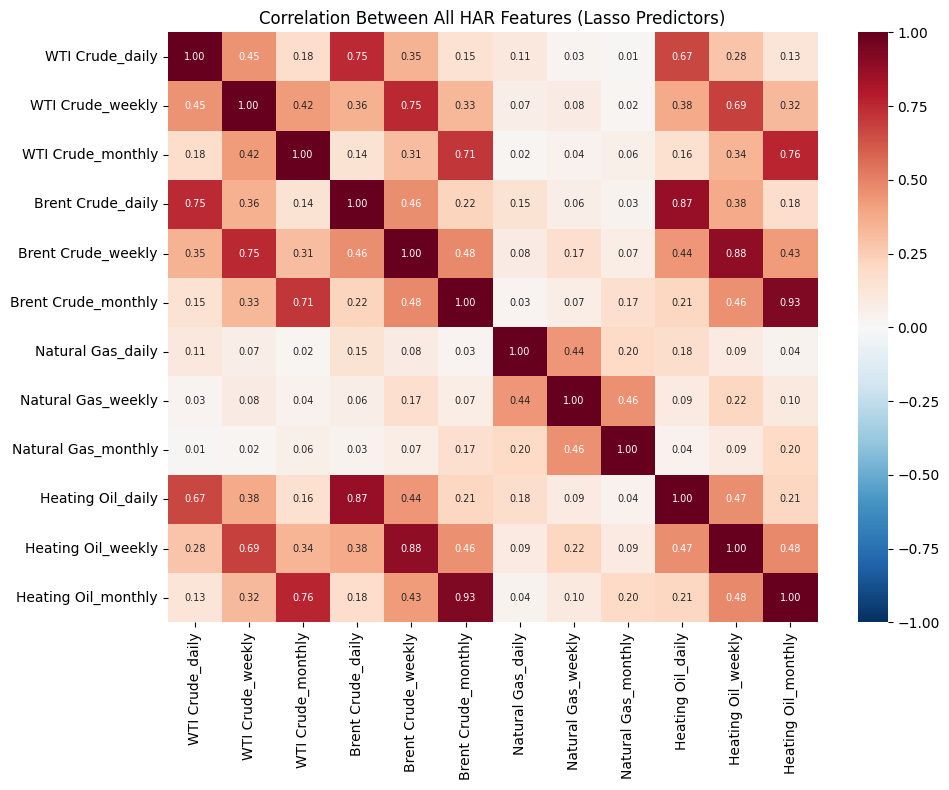


Key observations:
- High correlation between same-horizon features across oil types (WTI vs Brent) → Lasso should handle this via sparsity
- Low correlation between daily and monthly horizons → each horizon adds information


In [24]:
# Correlation between HAR features — are they redundant or diverse?
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(X_har.corr(), cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            annot=True, fmt='.2f', ax=ax, annot_kws={'size': 7})
ax.set_title('Correlation Between All HAR Features (Lasso Predictors)')
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- High correlation between same-horizon features across oil types (WTI vs Brent) → Lasso should handle this via sparsity")
print("- Low correlation between daily and monthly horizons → each horizon adds information")

## 14. Commodity → Stock Lead-Lag Preview

Do commodity returns predict next-day stock returns? Quick cross-correlation to sanity check before running the full Lasso.

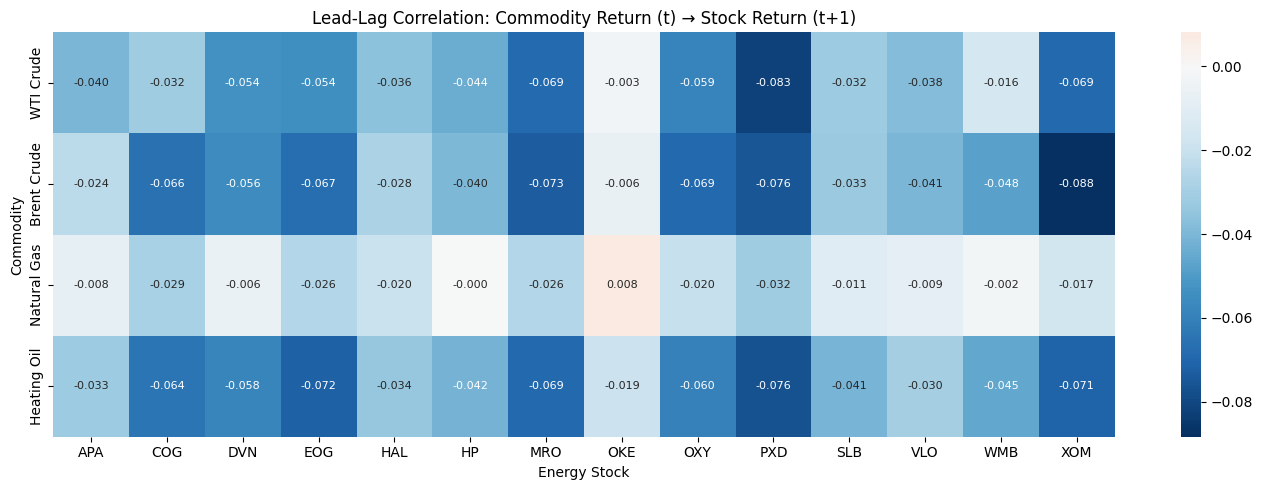

Interpretation: values close to 0 = no simple linear lead-lag.
This is expected — the HAR-Lasso model looks for more nuanced multi-horizon signals.


In [25]:
# Cross-correlation: commodity return today vs stock return tomorrow
# corr(r_commodity_t, r_stock_{t+1}) — a positive value suggests lead-lag
common_idx = comm_ret.index.intersection(energy_ret.index)
comm_aligned = comm_ret.loc[common_idx]
stock_aligned = energy_ret.loc[common_idx]

lead_lag_corr = pd.DataFrame(index=comm_aligned.columns, columns=stock_aligned.columns, dtype=float)
for c in comm_aligned.columns:
    for s in stock_aligned.columns:
        # commodity today → stock tomorrow
        lead_lag_corr.loc[c, s] = comm_aligned[c].corr(stock_aligned[s].shift(-1))

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(lead_lag_corr.astype(float), cmap='RdBu_r', center=0, annot=True, fmt='.3f',
            ax=ax, annot_kws={'size': 8})
ax.set_title('Lead-Lag Correlation: Commodity Return (t) → Stock Return (t+1)')
ax.set_ylabel('Commodity')
ax.set_xlabel('Energy Stock')
plt.tight_layout()
plt.show()

print("Interpretation: values close to 0 = no simple linear lead-lag.")
print("This is expected — the HAR-Lasso model looks for more nuanced multi-horizon signals.")

## 15. Commodity Volatility Regimes

How volatile are commodities during geopolitical events? This determines when the Lasso edges are most active.

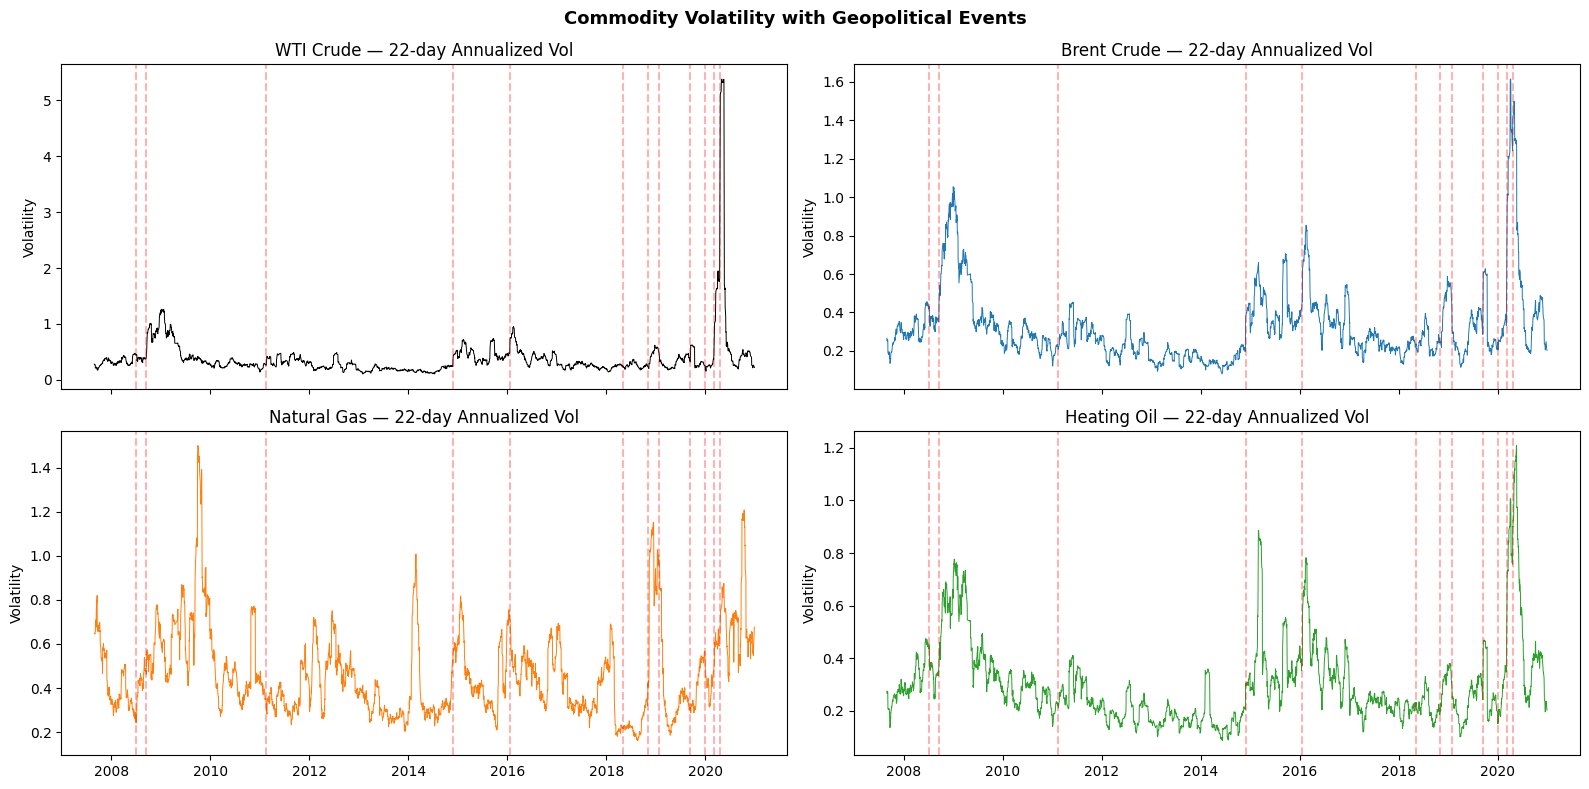

In [26]:
# 22-day rolling vol for each commodity
comm_rolling_vol = comm_ret.rolling(22).std() * np.sqrt(252)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
for ax, (col, color) in zip(axes.flat, zip(comm_rolling_vol.columns, colors)):
    ax.plot(comm_rolling_vol[col], color=color, linewidth=0.7)
    ax.set_title(f'{col} — 22-day Annualized Vol')
    ax.set_ylabel('Volatility')
    for _, row in events_df.iterrows():
        if row['date'] >= comm_rolling_vol.dropna().index[0]:
            ax.axvline(row['date'], color='red', alpha=0.3, linestyle='--')

plt.suptitle('Commodity Volatility with Geopolitical Events', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 16. Commodity vs Energy Stocks — Same Day Correlation

How tightly do commodities and energy stocks co-move? This is the *contemporaneous* relationship — the Lasso should find the *predictive* (lagged) one.

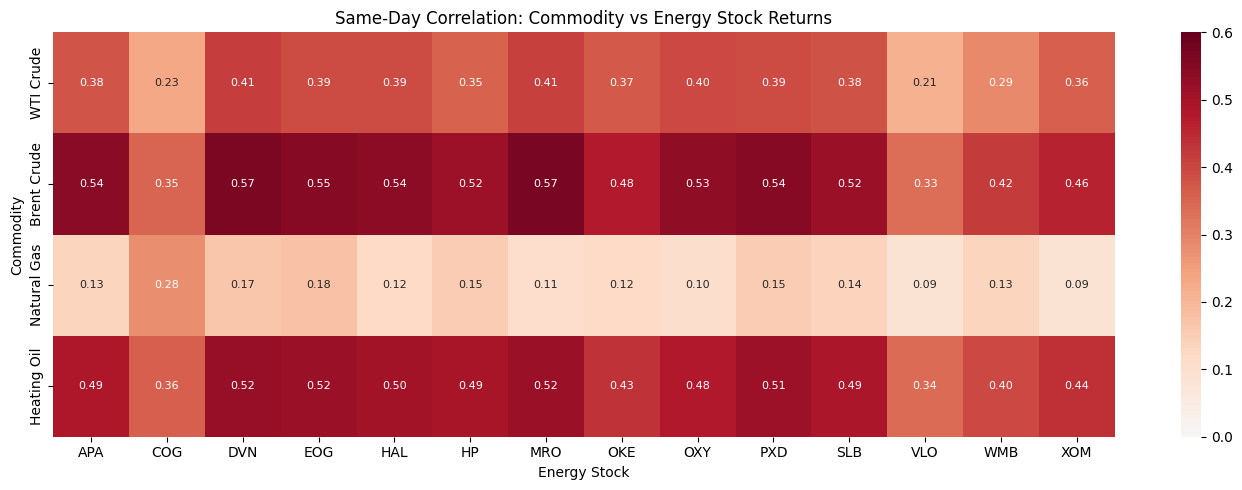

Stocks with higher same-day correlation to oil → likely more edges in the bipartite graph.
Stocks with low correlation → potentially interesting for lead-lag discovery.


In [27]:
# Same-day correlation: commodity vs stock
same_day_corr = pd.DataFrame(index=comm_aligned.columns, columns=stock_aligned.columns, dtype=float)
for c in comm_aligned.columns:
    for s in stock_aligned.columns:
        same_day_corr.loc[c, s] = comm_aligned[c].corr(stock_aligned[s])

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(same_day_corr.astype(float), cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            ax=ax, vmin=0, vmax=0.6, annot_kws={'size': 8})
ax.set_title('Same-Day Correlation: Commodity vs Energy Stock Returns')
ax.set_ylabel('Commodity')
ax.set_xlabel('Energy Stock')
plt.tight_layout()
plt.show()

print("Stocks with higher same-day correlation to oil → likely more edges in the bipartite graph.")
print("Stocks with low correlation → potentially interesting for lead-lag discovery.")

## 17. Rolling Commodity-Stock Correlation (Event Regime Detection)

Does the commodity → stock link strengthen during geopolitical shocks?

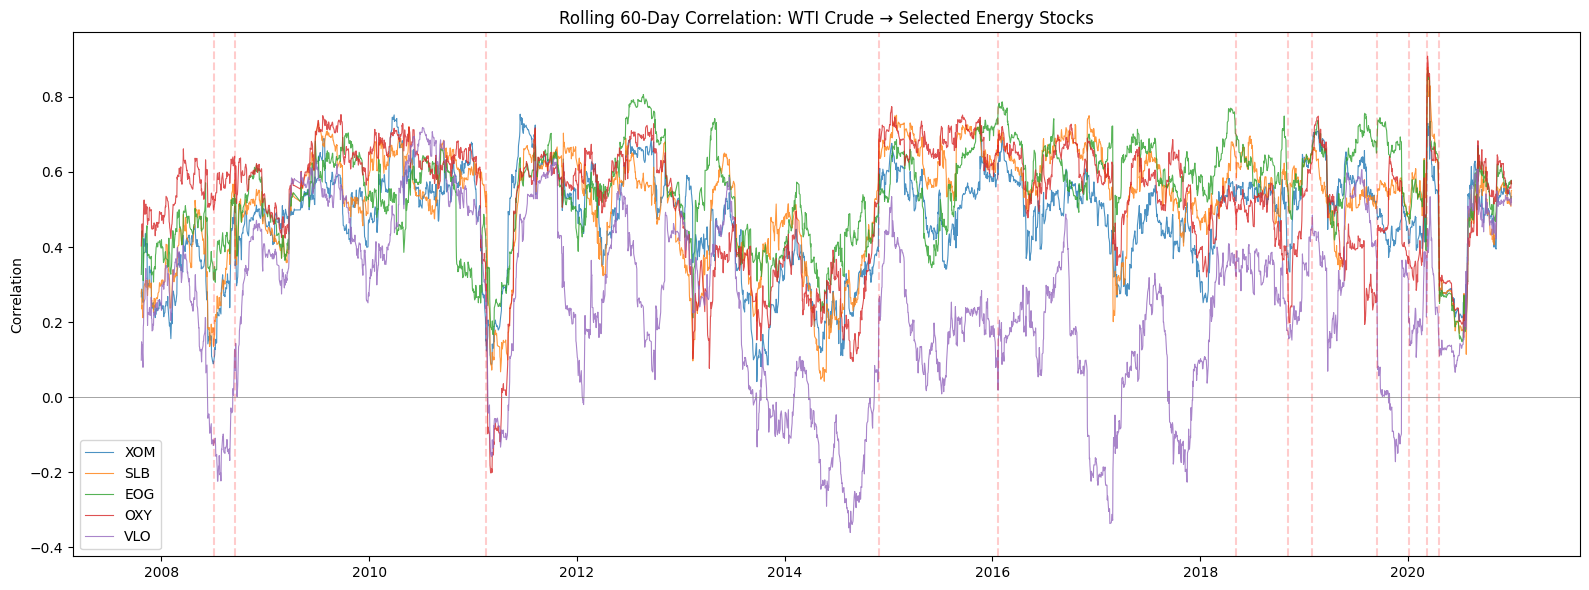

Notice: correlation is NOT constant — it spikes during shocks.
This is why a rolling-window Lasso (or event-conditioned model) matters.


In [28]:
# Rolling 60-day correlation between WTI and each energy stock
wti_col = [c for c in comm_ret.columns if 'WTI' in c or 'Crude' in c]
if wti_col:
    wti_ret = comm_ret[wti_col[0]].reindex(stock_aligned.index)

    fig, ax = plt.subplots(figsize=(16, 6))
    for s in ['XOM', 'SLB', 'EOG', 'OXY', 'VLO']:
        if s in stock_aligned.columns:
            rolling_c = wti_ret.rolling(60).corr(stock_aligned[s])
            ax.plot(rolling_c, linewidth=0.8, label=s, alpha=0.8)

    for _, row in events_df.iterrows():
        if row['date'] >= stock_aligned.index[60]:
            ax.axvline(row['date'], color='red', alpha=0.2, linestyle='--')

    ax.set_title('Rolling 60-Day Correlation: WTI Crude → Selected Energy Stocks')
    ax.set_ylabel('Correlation')
    ax.legend(loc='lower left')
    ax.axhline(0, color='gray', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    print("Notice: correlation is NOT constant — it spikes during shocks.")
    print("This is why a rolling-window Lasso (or event-conditioned model) matters.")
else:
    print("WTI data not available — skipping rolling correlation plot.")

---

## 18. Full Data Summary & Next Steps

In [29]:
# Date overlap between CRSP and commodity data
crsp_dates = set(energy_ret.index)
comm_dates = set(X_har.index)
overlap = sorted(crsp_dates & comm_dates)

print("=" * 65)
print("PROJECT DATA SUMMARY")
print("=" * 65)

print(f"\n--- CRSP Energy Stocks (Set S) ---")
print(f"  Stocks:  {len(energy_avail)} tickers: {energy_avail}")
print(f"  Missing: {missing} (not in CRSP universe)")
print(f"  Dates:   {energy_ret.index[0].date()} to {energy_ret.index[-1].date()}")
print(f"  Rows:    {energy_ret.shape[0]} trading days")
print(f"  Files:   pvCLCL (returns), OPCL (intraday), volume")

print(f"\n--- Commodity Futures (Set C) ---")
print(f"  Commodities: {list(comm_close.columns)}")
print(f"  Dates:       {comm_close.index[0].date()} to {comm_close.index[-1].date()}")
print(f"  Rows:        {comm_close.shape[0]} trading days")
print(f"  Source:      Yahoo Finance")

print(f"\n--- HAR Feature Matrix (Lasso X) ---")
print(f"  Shape: {X_har.shape} ({X_har.shape[0]} days x {X_har.shape[1]} features)")
print(f"  Features: {len(comm_close.columns)} commodities x 3 horizons = {X_har.shape[1]} predictors")

print(f"\n--- Overlapping Date Range ---")
print(f"  {overlap[0].date()} to {overlap[-1].date()}")
print(f"  {len(overlap)} common trading days")

print(f"\n--- Geopolitical Events ---")
print(f"  {len(EVENTS)} events in the sample window")

print(f"\n{'=' * 65}")
print(f"READY: All data available to build the HAR-Lasso bipartite network.")
print(f"{'=' * 65}")

PROJECT DATA SUMMARY

--- CRSP Energy Stocks (Set S) ---
  Stocks:  14 tickers: ['APA', 'COG', 'DVN', 'EOG', 'HAL', 'HP', 'MRO', 'OKE', 'OXY', 'PXD', 'SLB', 'VLO', 'WMB', 'XOM']
  Missing: ['COP', 'CVX', 'FTI', 'HES', 'HFC', 'KMI', 'MPC', 'NBL', 'NOV', 'PSX', 'XEC'] (not in CRSP universe)
  Dates:   2000-01-03 to 2020-12-31
  Rows:    5279 trading days
  Files:   pvCLCL (returns), OPCL (intraday), volume

--- Commodity Futures (Set C) ---
  Commodities: ['WTI Crude', 'Brent Crude', 'Natural Gas', 'Heating Oil']
  Dates:       2000-08-23 to 2020-12-30
  Rows:        5111 trading days
  Source:      Yahoo Finance

--- HAR Feature Matrix (Lasso X) ---
  Shape: (3263, 12) (3263 days x 12 features)
  Features: 4 commodities x 3 horizons = 12 predictors

--- Overlapping Date Range ---
  2007-08-30 to 2020-12-30
  3261 common trading days

--- Geopolitical Events ---
  15 events in the sample window

READY: All data available to build the HAR-Lasso bipartite network.
